---

### 🎓 **Professor**: Apostolos Filippas

### 📝 **Student**: Leonard Chiang

### 📘 **Class**: AI Engineering, [repo `@lchiangnyc/ai-engineering-fordham`](https://github.com/lchiangnyc/ai-engineering-fordham)

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [93]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional, Callable
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

# Additional imports to my taste
# Visualizing grade distributions
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import squarify     # Algorithm for treemap visualization
from matplotlib import colors

# Preparing for pydantic schema
from typing import Literal

# Timing searches
import time

# Coordinating LLM calls
import asyncio

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [99]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [2]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


_I used the Terminal to bring the CSV files toward my working directory (and to take up the changes made to the Lecture 3 Notebook), confirming the file handling syntax with a [Codecademy reference](https://www.codecademy.com/article/command-line-commands#heading-file-handling). See below:_

_I will not be pushing these datafiles to my repo, on the presumption that the reader already has them on hand if they're needed._

### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [3]:
# Task 2a: Load the data

# YOUR CODE HERE
# Isolating directory filepath as coding best practice
data_path = "C:/Users/leona/ai-engineering-fordham/data"

# Loading DataFrames in order of function definition
    # N.B. DF refers to DataFrame, NOT document frequency
products_DF = load_wands_products(data_dir = data_path)
queries_DF = load_wands_queries(data_dir = data_path)
labels_DF = load_wands_labels(data_dir = data_path)

In [4]:
# Defining simple function to display DataFrames' row counts
def extract_DF_rows(DF_tuple):
    # Extracting rows dimension (index 0) of .shape tuple
    # Setting f-string column widths for tidiness
        # Ref. https://docs.python.org/3/tutorial/inputoutput.html#formatted-string-literals
    printout = print(f"{DF_tuple[0]:11} comprises {DF_tuple[1].shape[0]:6} rows") # of {DF_tuple[0].replace("_DF", "")}")
    return printout

In [5]:
pql_list = [("products_DF", products_DF), ("queries_DF", queries_DF), ("labels_DF", labels_DF)]     # pql for products, queries, labels
for tuple in pql_list:
    extract_DF_rows(tuple)

products_DF comprises  42994 rows
queries_DF  comprises    480 rows
labels_DF   comprises 233448 rows


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [6]:
# YOUR CODE HERE
# Listing the available columns
print(f"Listing available columns:\n  {list(products_DF.columns)}\n")

Listing available columns:
  ['product_id', 'product_name', 'product_class', 'category_hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count']



In [7]:
# YOUR CODE HERE
# Displaying a selection of products_DF
products_DF.tail(5)

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
42989,42989,malibu pressure balanced diverter fixed shower...,Shower Panels,Home Improvement / Bathroom Remodel & Bathroom...,the malibu pressure balanced diverter fixed sh...,producttype : shower panel|spraypattern : rain...,3.0,4.5,2.0
42990,42990,emmeline 5 piece breakfast dining set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,NaN,basematerialdetails : steel| : gray wood|ofhar...,1314.0,4.5,864.0
42991,42991,maloney 3 piece pub table set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,this pub table set includes 1 counter height t...,additionaltoolsrequirednotincluded : power dri...,49.0,4.0,41.0
42992,42992,fletcher 27.5 '' wide polyester armchair,Teen Lounge Furniture|Accent Chairs,Furniture / Living Room Furniture / Chairs & S...,"bring iconic , modern style to your space in a...",legmaterialdetails : rubberwood|backheight-sea...,1746.0,4.5,1226.0
42993,42993,griffin 29 '' bar stool,Bar Stools,Furniture / Kitchen & Dining Furniture / Bar F...,this set of two barstools features a minimalis...,distancebetweenfloorandfootrest:7.5|dssecondar...,20.0,4.5,20.0


In [8]:
# Exploring DataFrame columns
    # Ack. I learned of df.info() and df.describe() Fall '25 whilst tutoring Computational Finance students of Profs. Chidambaran and Simaan
display(products_DF.info())
display(products_DF.describe())

<class 'pandas.DataFrame'>
RangeIndex: 42994 entries, 0 to 42993
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           42994 non-null  int64  
 1   product_name         42994 non-null  str    
 2   product_class        40142 non-null  str    
 3   category_hierarchy   41438 non-null  str    
 4   product_description  36986 non-null  str    
 5   product_features     42994 non-null  str    
 6   rating_count         33542 non-null  float64
 7   average_rating       33542 non-null  float64
 8   review_count         33542 non-null  float64
dtypes: float64(3), int64(1), str(5)
memory usage: 3.0 MB


None

,product_id,rating_count,average_rating,review_count
count,42994.000000,33542.000000,33542.000000,33542.000000
mean,21496.500000,430.270437,4.530126,284.250343
std,12411.443073,2407.921579,0.509263,1539.611737
min,0.000000,1.000000,1.000000,0.000000
25%,10748.250000,8.000000,4.500000,6.000000
50%,21496.500000,42.000000,4.500000,31.000000
75%,32244.750000,195.000000,5.000000,131.000000
max,42993.000000,109226.000000,5.000000,61362.000000


**_For the purposes of this week of the course, those focus should go to the textual columns (indexed 1, 2, 3, 4, and 5 above)._**

_In real life,_
* _a website's interface might include ways to incorporate ratings/review data into the query;_
* _and select users might search for_ `product_id` _(index 0), as an edge case._

In [9]:
# YOUR CODE HERE
print(f"Candidate columns:\n  {list(products_DF.columns[1:6])}")

Candidate columns:
  ['product_name', 'product_class', 'category_hierarchy', 'product_description', 'product_features']


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

In [10]:
# Task 2c: Understand judgments

# YOUR CODE HERE
labels_values = dict(labels_DF["grade"].value_counts())
print(labels_values)

{1: np.int64(146633), 0: np.int64(61201), 2: np.int64(25614)}


In [11]:
labels_DF.info()
grade_vc = labels_DF["grade"].value_counts()     # vc for value counts
grade_vc_n = labels_DF["grade"].value_counts(normalize = True)     # _n for normalized
print(f"\n== Counts of grades, decreasing order ==\n{grade_vc}",
    f"\n\n== Counts of grades, decreasing order, normalized",
    f"\n  (for ease of later conversion to pct.) == \n{grade_vc_n}")

<class 'pandas.DataFrame'>
RangeIndex: 233448 entries, 0 to 233447
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   id          233448 non-null  int64
 1   query_id    233448 non-null  int64
 2   product_id  233448 non-null  int64
 3   label       233448 non-null  str  
 4   grade       233448 non-null  int64
dtypes: int64(4), str(1)
memory usage: 8.9 MB

== Counts of grades, decreasing order ==
grade
1    146633
0     61201
2     25614
Name: count, dtype: int64 

== Counts of grades, decreasing order, normalized 
  (for ease of later conversion to pct.) == 
grade
1    0.628118
0    0.262161
2    0.109720
Name: proportion, dtype: float64


_Noting_ `value_counts()` _is indexed by <u>grade</u>, such that its values will not be accessed by_ `[`_position_`]`_._

_To confirm labels and grades map on a strictly mutual 1:1 basis, and that these designations have full coverage of the DataFrame,_

In [ ]:
# Double-indexing to detect any mismatches
lg_vc = labels_DF[["label", "grade"]].value_counts()
gl_vc = labels_DF[["grade", "label"]].value_counts()

# Setting conditions
map_bool = (lg_vc.values.all() == gl_vc.values.all())
coverage_bool = (sum(lg_vc) == sum(gl_vc) == len(labels_DF))

# Using conditions
if map_bool and coverage_bool:
    print(f"{lg_vc}\n\n{gl_vc}")

label       grade
Partial     1        146633
Irrelevant  0         61201
Exact       2         25614
Name: count, dtype: int64

grade  label     
1      Partial       146633
0      Irrelevant     61201
2      Exact          25614
Name: count, dtype: int64


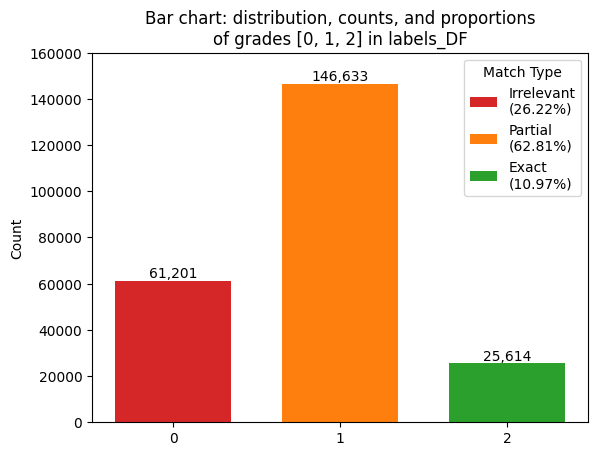

In [13]:
# Establishing plot area
fig, ax = plt.subplots()

# Preparing colored-bar chart with labels
    # Ref. https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.html
# Setting x-values
bar_grades = [0, 1, 2]
# Setting y-values
bar_counts = [grade_vc[0], grade_vc[1], grade_vc[2]]
# Setting labels for legend
    # Converting normalized value counts to percentages
bar_labels = [
    f"Irrelevant\n({grade_vc_n[0]:,.2%})",
    f"Partial\n({grade_vc_n[1]:,.2%})",
    f"Exact\n({grade_vc_n[2]:,.2%})"
    ]
# Setting colors
bar_colors = ["tab:red", "tab:orange", "tab:green"]

# Plotting
bar_container = ax.bar(bar_grades, bar_counts,
    label = bar_labels, color = bar_colors, width = 0.7)
# Tagging each bar with (unnormalized) value count
ax.bar_label(bar_container, fmt = "{:,.0f}")

# Limiting x-tickmarks to integer values
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.set_ylabel("Count")
ax.set_ylim(0, 160000)

ax.set_title(f"Bar chart: distribution, counts, and proportions" +
    f"\nof grades {bar_grades} in labels_DF")

ax.legend(title = "Match Type")

plt.show()

> ##### _**<u>NOTE TO THE READER</u>:**_ _The following Cell uses_ `squarify`_, a lesser-known package which is less likely to already be on hand. Run_ `uv add squarify` _(or_ `pip install squarify`_) as necessary to execute it. Relevant dependencies are logged in files_ `pyproject.toml` _and_ `uv.lock`_._

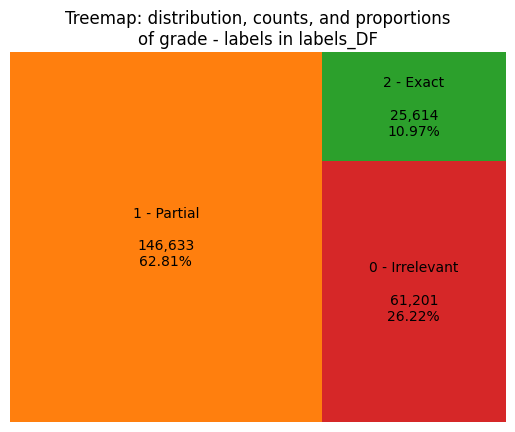

In [14]:
# YOUR CODE HERE
# Supplying value_counts
    # NB differing order from bar chart
        # squarify requires values supplied in decreasing order to work properly 
            # https://github.com/laserson/squarify?tab=readme-ov-file#documentation-for-squarify
tree_counts = [grade_vc[1], grade_vc[0], grade_vc[2]]     # != bar_counts

# Displaying information on treemap segments
    # Again, note differing order
tree_labels = [     # != bar_labels
    f"1 - Partial\n\n{grade_vc[1]:,.0f}\n{grade_vc_n[1]:,.2%}",
    f"0 - Irrelevant\n\n{grade_vc[0]:,.0f}\n{grade_vc_n[0]:,.2%}",
    f"2 - Exact\n\n{grade_vc[2]:,.0f}\n{grade_vc_n[2]:,.2%}"
    ]
tree_colors = ["tab:orange", "tab:red", "tab:green"]     # != bar_colors

fig, ax = plt.subplots()

# Plotting
ax = squarify.plot(sizes = tree_counts, label = tree_labels,
    color = tree_colors, alpha = 1)     # alpha (normalized to 1) adjusts color transparency    

# Hiding axis
ax.axis("off")

ax.set_title(f"Treemap: distribution, counts, and proportions" +
    f"\nof grade - labels in labels_DF")

plt.show()

---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [15]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [16]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

`score_bm25()` _and_ `search_products()` _just got a special call-out, so I study their definitions, taking care to note dependencies. Recalling that_ `build_index()` _returns_ `index` _and_ `doc_lengths` _(see line 47), I emerge with this to-do list:_

#### _Table 1. Creating BM25 index of_ `product_name` _field_
| _Parameter_ | _Role(s)_ | _Action_ |
| - | - | - |
| `query` | _Passed into search for use in score_ | _Compose later_ |
| `products_df` | _Passed into search for use in score_ | _Pass_ `products_DF` |
| `num_docs` | _score only;<br>derived as_ `len(products_df)` | _Pass_ `products_DF` |
| `index` | _Passed into search for use in score_ | _Obtain via_ `build_index()` |
| `doc_lengths` | _Passed into search for use in score_ | _Obtain via_ `build_index()` |
| `tokenizer` | _Passed into search for use in score_ | _Use provided_ `snowball_tokenize()` |
| `k` | _search only_ | _Consider keeping default value,_ $10$ |
| `k1` | _score only_ | _Keep default value,_ $1.2$ |
| `b` | _score only_ | _Keep default value,_ $0.75$ |

_I'll need to cast_ `products_DF["product_name"]` _(from a_ `Series`_) into_ `list` _to meet_ `build_index()`_'s type requirement._

In [17]:
# Task 3a: Create BM25 index for product_name

# YOUR CODE HERE
name_column = products_DF["product_name"]
print(f"name_column is of type {type(name_column)}")

name_column is of type <class 'pandas.Series'>


In [18]:
name_list = list(name_column)
name_index, name_lengths = build_index(name_list, snowball_tokenize)

pd.DataFrame.from_dict(
    {"name_index" : ["dictionary", f"{len(name_index.keys())} token-keys"],
     "name_lengths" : ["list", f"{len(name_lengths)} document-lengths"]},
    orient = "index", columns = ["datatype", "contains"])

,datatype,contains
name_index,dictionary,25570 token-keys
name_lengths,list,42994 document-lengths


In [19]:
top = 10
search_query = "chair"

start_time = time.time()
results_name_DF = search_products(
    query = search_query,
    products_df = products_DF,
    index = name_index,
    doc_lengths = name_lengths,
    tokenizer = snowball_tokenize,
    k = top
    )
display(results_name_DF)
elapsed_time = time.time() - start_time
print(f"Top {top} search results for \"{search_query}\" returned in {elapsed_time:,.4f} seconds")

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
251,251,chair chair,Stackable Chairs|Dining Chairs,Furniture / Kitchen & Dining Furniture / Dinin...,an unassuming take on the everyday side chair ...,mainmaterialseatbackwoodspecies : ebony|overal...,NaN,NaN,NaN,4.384526,1
4410,4410,chair,NaN,Outdoor / Outdoor & Patio Furniture / Outdoor ...,NaN,framecolor : white|style : traditional|outerfr...,NaN,NaN,NaN,3.927084,2
34536,34536,adjustable swivel office chair computer chair ...,Office Chairs,Furniture / Office Furniture / Office Chairs,this task chair is a colorful addition to your...,overallheight-toptobottom:34.25|overallwidth-s...,94.0,4.5,75.0,3.883785,3
26256,26256,"office chair high back desk chair , gaming cha...",Office Chairs,Furniture / Office Furniture / Office Chairs,if you have sedentary job and sit for long tim...,mainwoodjoinerymethod : basic butt|warrantylen...,4.0,3.5,4.0,3.801761,4
19498,19498,ergonomic task chair task chair,Office Chairs,Furniture / Office Furniture / Office Chairs,NaN,weightcapacitybucket:300 lbs - 349 lbs|fullorl...,NaN,NaN,NaN,3.778350,5
42637,42637,velvet task chair task chair,Office Chairs,Furniture / Office Furniture / Office Chairs,the office chair is ideal for any casual or pr...,castertype : soft|seatdepth-fronttoback:18.8|s...,NaN,NaN,NaN,3.778350,6
33691,33691,lift chair office work chair beauty salon chai...,Office Chairs,Furniture / Office Furniture / Office Chairs,NaN,recommendeddailyusage : light usage ( up to 4 ...,NaN,NaN,NaN,3.731244,7
8137,8137,"plastic chair for dining room , outdoor chair ...",Dining Chairs,Furniture / Kitchen & Dining Furniture / Dinin...,specifications : seat materials : plastic chai...,legcolor : black|backstyle : cross back|overal...,NaN,NaN,NaN,3.731244,8
21190,21190,ergonomic mesh chair computer chair home execu...,Office Chairs,Furniture / Office Furniture / Office Chairs,the office chair is ideal for any casual or pr...,seatmaterial : mesh|producttype : conference c...,1.0,5.0,1.0,3.708129,9
2187,2187,fashion casual lift chair office work chair be...,NaN,Furniture / Office Furniture / Office Chairs,it is a new product with absolutely no damage .,backcolor : black|armresttype : fixed|framemat...,NaN,NaN,NaN,3.621372,10


Top 10 search results for "chair" returned in 0.0416 seconds


_Excuse me for laughing aloud over the fact that querying for "chair" returns the seemingly [reduplicated](https://en.wikipedia.org/wiki/Reduplication) "chair chair"– now with double the chair-ness of "chair" (rank 2)! The sheer on-the-nose simplicity of each of these make result #3 look like it's trying too hard.<br>Upon reflection, this is a pretty sensible outcome, since the calculations take document length into account._

_Slicing to make the outcome more readable:_

In [ ]:
# Setting slicer
slicer_name = ["rank", "score", "product_id", "product_name"]

# Reindexing by bm25 rank
results_name_DF_sliced = results_name_DF[slicer_name].set_index("rank")
display(results_name_DF_sliced)

,score,product_id,product_name
rank,,,
1,4.384526,251,chair chair
2,3.927084,4410,chair
3,3.883785,34536,adjustable swivel office chair computer chair ...
4,3.801761,26256,"office chair high back desk chair , gaming cha..."
5,3.778350,19498,ergonomic task chair task chair
6,3.778350,42637,velvet task chair task chair
7,3.731244,33691,lift chair office work chair beauty salon chai...
8,3.731244,8137,"plastic chair for dining room , outdoor chair ..."
9,3.708129,21190,ergonomic mesh chair computer chair home execu...


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [21]:
# Task 3b: Add product_description to search

# YOUR CODE HERE
desc_column = products_DF["product_description"]
print(f"desc_column is of type {type(desc_column)}")

desc_column is of type <class 'pandas.Series'>


In [22]:
desc_list = list(desc_column)     # desc for description
desc_index, desc_lengths = build_index(desc_list, snowball_tokenize)
print(f"dictionary desc_index has {len(desc_index.keys())} token-keys,",
    f"\nlist desc_lengths holds the lengths of {len(desc_lengths)} description-documents")

dictionary desc_index has 20386 token-keys, 
list desc_lengths holds the lengths of 42994 description-documents


#### _Table 2. Assorted multi-field scoring/-ed approaches_

| _Source_ | _Function_ | _Score Type_ | _Field Treament_ | _Field-Score Aggregation_ |
| - | - | - | - | - |
| _Lecture 3_ | `score_multifield_naive()` | _simple tf*idf_ | _per_ | _sum_ |
| _Lecture 3_ | `score_multifield_dismax()` | _simple tf*idf_ | _per_ | _max_ |
| _Lecture 3_ | `score_bm25f()` | _bm25_ | _combined:<br> score takes tf sum, df max_ | _N/A_ |
| <br> | <br> | <br> | <br> | <br> |
| _Leonard_ | `score_bm25_mf_naive()` | _<u>bm25</u>_ | _per_ | _sum_ |
| _Leonard_ | `search_products_bm25f_blend()` | _bm25_ | _combined:<br> score takes tf sum, df max (default) <u>or</u> sum_  | _N/A_ |

_Adopting but adapting <u>naive</u> multi-field function from class (as practice managing function parameters),_

In [23]:
def score_bm25_mf_naive(     # mf for multi-field
    query: str, fields: dict, num_docs: int,
    tokenizer: Callable[str] = snowball_tokenize) -> np.ndarray[float]:
    
    """
    Naive multi-field BM25 scoring:
        per-field tf, per-field idf scoring,
        aggregated as unweighted sum across all supplied fields.
    
    Args:
        query: The search query
        fields: Nominated fields' respective inverted indices and document lengths
        num_docs: Total number of documents
        tokenizer: Tokenization function, default snowball_tokenize
        
    Returns:
        Array of scores for each document
    """

    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)

    for token in query_tokens:
        for field_name, (field_index, field_doc_lengths) in fields.items():
            # print(field_name, (len(field_index), len(field_doc_lengths)))
            avg_doc_len = np.mean(field_doc_lengths)
            
            df = get_df(token, field_index)
            if df == 0:
                continue
            
            idf_bm25 = bm25_idf(df, num_docs)
        
            if token in field_index:
                for doc_id in range(num_docs):
                    tf = get_tf(token, doc_id, field_index)
                    tf_bm25 = bm25_tf(tf, field_doc_lengths[doc_id], avg_doc_len)
                    scores[doc_id] += idf_bm25 * tf_bm25
                    # print(scores[doc_id])

    return scores

# Using above scoring 
def search_products_bm25_mfn(     # mfn for "multi-field naive"
    query: str, products_df: pd.DataFrame, fields: dict,
    tokenizer = snowball_tokenize, k: int = 10) -> tuple[pd.DataFrame, str]:
    
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        fields: Nominated fields' respective inverted indices and document lengths
        tokenizer: Tokenization function, default snowball_tokenize()
        k: Number of results to return, default 10
        
    Returns:
        DataFrame with top-k products and scores
    """
    start_time = time.time()

    num_docs = len(products_df)

    scores_bm25_mfn = score_bm25_mf_naive(
        query, fields, num_docs, tokenizer)
    top_k_idx = np.argsort(-scores_bm25_mfn)[:k]
    
    results_mfn_DF = products_df.iloc[top_k_idx].copy()
    results_mfn_DF["bm25_mfn score"] = scores_bm25_mfn[top_k_idx]
    results_mfn_DF["rank"] = range(1, k + 1)

    elapsed_time = time.time() - start_time

    field_string = f"{len(fields.keys())} fields searched;"
    time_string = f"\n  Top {k} results retrieved in {elapsed_time:.4f} seconds"
    output_string = field_string + time_string

    return results_mfn_DF, output_string

_Now pursuing BM25<u>F</u> multi-field blending,_

In [24]:
# Taking more direclty from Lecture 3,
def score_bm25f_blended(
    query: str, indices: dict, doc_lengths_dict: dict, num_docs: int,
    agg: Literal[max|sum] = max, tokenizer = snowball_tokenize,
    k1: float = 1.2, b: float = 0.75):
    """
    BM25F scoring: blend TF across fields before applying IDF.
    
    Args:
        indices: dict of {field_name: index}
        doc_lengths_dict: dict of {field_name: [lengths]}
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    
    # Calculate average doc length across all fields
    total_lengths = np.zeros(num_docs)
    for field_lengths in doc_lengths_dict.values():
        total_lengths += np.array(field_lengths)
    avg_doc_len = np.mean(total_lengths)
    
    for token in query_tokens:
        # Calculate combined DF (max across fields)
        combined_df = 0
        for index in indices.values():
            # Controlling for aggregation mode
            if agg == max:
                combined_df = max(combined_df, get_df(token, index))
            elif agg == sum:
                combined_df = sum(combined_df, get_df(token, index))
        
        if combined_df == 0:
            continue
        
        # Use combined DF for IDF
        idf = bm25_idf(combined_df, num_docs)
        
        for doc_id in range(num_docs):
            # Combine TF across fields (with length normalization per field)
            combined_impact = 0
            
            for field_name, index in indices.items():
                tf = get_tf(token, doc_id, index)
                if tf > 0:
                    doc_len = doc_lengths_dict[field_name][doc_id]
                    avg_field_len = np.mean(doc_lengths_dict[field_name])
                    # Length-normalized impact
                    impact = tf / (1 - b + b * doc_len / avg_field_len)
                    combined_impact += impact
            
            if combined_impact > 0:
                # Apply TF saturation to combined impact
                saturated = combined_impact / (combined_impact + k1)
                scores[doc_id] += idf * saturated
    
    return scores

def search_products_bm25f_blend(
    query: str, products_df: pd.DataFrame, fields: dict,
    agg: Literal[max|sum] = max, tokenizer = snowball_tokenize,
    k: int = 10) -> tuple[pd.DataFrame, str]:
    
    start_time = time.time()

    num_docs = len(products_df)

    indices = fields["indices"]
    doc_lengths_dict = fields["lengths"]

    scores_bm25f_blended = score_bm25f_blended(
        query, indices, doc_lengths_dict, num_docs)
    top_k_idx = np.argsort(-scores_bm25f_blended)[:k]
    
    results_bm25f_DF = products_df.iloc[top_k_idx].copy()
    results_bm25f_DF["bm25f score"] = scores_bm25f_blended[top_k_idx]
    results_bm25f_DF["rank"] = range(1, k + 1)

    elapsed_time = time.time() - start_time

    fields_string = f"{len(indices.keys())} fields ({list(indices.keys())}) searched;"
    time_string = f"\n  Top {k} results retrieved in {elapsed_time:.4f} seconds"
    output_string = fields_string + time_string

    return results_bm25f_DF, output_string


In [25]:
mfn_nd_dict = {
    "product_name" : (name_index, name_lengths),
    "product_description" : (desc_index, desc_lengths)
    }

In [26]:
# Running simple test query
search_query = "chair"
results_mfn_nd = search_products_bm25_mfn(     # nd for name and description
    query = search_query,
    products_df = products_DF,
    fields = mfn_nd_dict,
    )

In [27]:
# Bringing back name-only results for comparison
display(results_name_DF_sliced)

,score,product_id,product_name
rank,,,
1,4.384526,251,chair chair
2,3.927084,4410,chair
3,3.883785,34536,adjustable swivel office chair computer chair ...
4,3.801761,26256,"office chair high back desk chair , gaming cha..."
5,3.778350,19498,ergonomic task chair task chair
6,3.778350,42637,velvet task chair task chair
7,3.731244,33691,lift chair office work chair beauty salon chai...
8,3.731244,8137,"plastic chair for dining room , outdoor chair ..."
9,3.708129,21190,ergonomic mesh chair computer chair home execu...


In [28]:
# Slicing DataFrame of results for improved readability, reindexing by bm25 rank
# Extracting DataFrame from returned tuple
results_mfn_nd_DF = results_mfn_nd[0]
mfn_nd_slicer = ["rank", "bm25_mfn score", "product_id", "product_name"]

results_nd_DF_sliced = results_mfn_nd_DF[mfn_nd_slicer].set_index("rank")

display(results_nd_DF_sliced)
print(results_mfn_nd[1])

,bm25_mfn score,product_id,product_name
rank,,,
1,8.233572,15612,massage chair
2,7.899228,22744,seager parsons chair
3,7.569009,33457,wynn executive chair
4,7.550835,834,sundale folding floor chair gaming chairs for ...
5,7.524344,24466,kids chair
6,7.488055,14492,bubble chair stand
7,7.434061,251,chair chair
8,7.407845,1372,chair cushion
9,7.407845,17888,executive chair


2 fields searched;
  Top 10 results retrieved in 0.1039 seconds


_The top 10 results for each search seem to exhibit no overlap whatsover. I'll confirm:_

In [29]:
# Comparing product_id series of each 
print("== TOP 10s' OVERLAP: sole-field name vs. naive m-f name+desc ==")
display(results_name_DF_sliced["product_id"] == results_nd_DF_sliced["product_id"])

== TOP 10s' OVERLAP: sole-field name vs. naive m-f name+desc ==


rank
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
Name: product_id, dtype: bool

In [30]:
# Running simple test query
search_query = "chair"
bm25f_nd_dict = {
    "indices" : {
        "product_name" : name_index,
        "product_description" : desc_index
        },
    "lengths" : {
        "product_name" : name_lengths,
        "product_description" : desc_lengths
        }
    }

results_bm25f_nd = search_products_bm25f_blend(     # nd for name and description
    query = search_query,
    products_df = products_DF,
    fields = bm25f_nd_dict,
    )

In [31]:
# Slicing DataFrame of results for improved readability, reindexing by bm25 rank
# Extracting DataFrame from returned tuple
results_bm25f_nd_DF = results_bm25f_nd[0]
bm25f_nd_slicer = ["rank", "bm25f score", "product_id", "product_name"]

results_bm25f_nd_sliced = results_bm25f_nd_DF[bm25f_nd_slicer].set_index("rank")

display(results_bm25f_nd_sliced)
print(results_bm25f_nd[1])

,bm25f score,product_id,product_name
rank,,,
1,2.136113,15612,massage chair
2,2.115412,22744,seager parsons chair
3,2.106099,6519,straus 27.6 '' wide velvet side chair
4,2.102776,284,adjustable 360 degree swivel velvet desk chair...
5,2.063560,834,sundale folding floor chair gaming chairs for ...
6,2.005805,33457,wynn executive chair
7,2.003229,8122,ferebee 22 '' wide slipper chair
8,2.003103,12659,ergonomic mesh task chair
9,1.998478,8121,ferebee 22.5 '' wide slipper chair


2 fields (['product_name', 'product_description']) searched;
  Top 10 results retrieved in 15.8918 seconds


In [32]:
print("== TOP 10s' OVERLAP: sole-field name vs. max-blended m-f name+desc ==")     # m-f for multi-field
display(results_name_DF_sliced["product_id"] == results_bm25f_nd_sliced["product_id"])
print("\n== TOP 10s' OVERLAP: naive m-f name+desc vs. max-blended m-f name+desc ==")
display(results_nd_DF_sliced["product_id"] == results_bm25f_nd_sliced["product_id"])

== TOP 10s' OVERLAP: sole-field name vs. max-blended m-f name+desc ==


rank
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
Name: product_id, dtype: bool


== TOP 10s' OVERLAP: naive m-f name+desc vs. max-blended m-f name+desc ==


rank
1      True
2      True
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
Name: product_id, dtype: bool

_I take that the multi-field approaches seem to have more in common with each than either shares with the sole-field search._

_Testing the max/sum toggle in_ `results_bm25f_nd_max()`_,_

In [33]:
results_bm25f_nd_max = search_products_bm25f_blend(     # nd for name and desc., max for doc. freq. agg.
    query = search_query,
    products_df = products_DF,
    fields = bm25f_nd_dict,
    agg = sum)

print(f"Sum-aggregated search executed")

Sum-aggregated search executed


_Further comparison of search results is left up to the sufficiently motivated reader._

---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position $k$.
- We call this ${\text{precision}}@3$, and more generally ${\text{precision}}@k$ is the ratio of relevant results to total results at position $k$.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have ${\text{precision}}@3 = 2/3$.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### C. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good, some bad
- **NDCG = 0.0**: Worst -- results are totally irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [ ]:
# Task 4a: Answer in a comment
# Why does DCG use log2 for the discount? What's the effect on position 1 vs position 10?
#
# YOUR ANSWER HERE
"""
i: Re log2 for discount

Drawing on recollections from undergrad about

...calculus,
    the logarithm is a monotonically increasing function (always growing)
    whose derivative is monotonically decreasing
    (rate of growth is always slowing down). Hence a given position's
    gain will always contribute toward DCG, but the contributions toward
    "search strength" drop off as i increases.

...statistical mechanics (information theory qua thermodynamics),
    log2 refers to bits (a programming-related concept),
    and that's the only reason I can think of for using 2 as a logarithmic base
    over, say, e.


ii: Re pos. 1 versus pos. 10
As i grows, i + 1 grows, and log_2(i + 1)– that is, the denominator– grows.
As desired, the gain at position k attenuates.
"""
print("(Responses commented as multi-line string above)")

(Responses commented as multi-line string above)


### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

_Reproducing the formulas for ease of reference, observing that, because the ideal relevance grade is always 2, the RHS expression for NDCG can be simplified to reduce clutter when hand-coding:_

$$\text{gain}_i = \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$
$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$
$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}} = \frac{\text{DCG}}{{3 \sum_{i=1}^k \frac{1}{\log_2(i + 1)}}}$$

In [35]:
# Task 4b: Calculate NDCG by hand

# YOUR CODE HERE
# Having not the slightest how to do log2 without using prefab code,
    # Ref. https://numpy.org/doc/2.1/reference/generated/numpy.log2.html

gah1 = ((2 ** (1)) - 1) / np.log2((1) + 1)     # gah for gain - actual, by hand
gah2 = ((2 ** (2)) - 1) / np.log2((2) + 1)
gah3 = ((2 ** (1)) - 1) / np.log2((3) + 1)
gah4 = ((2 ** (0)) - 1) / np.log2((4) + 1)
gah5 = ((2 ** (2)) - 1) / np.log2((5) + 1)

# In the ideal case, relevance_{i} = 2 always
gih1  = (3) / np.log2((1) + 1)     # gih for gain - ideal, by hand
gih2  = (3) / np.log2((2) + 1)
gih3  = (3) / np.log2((3) + 1)
gih4  = (3) / np.log2((4) + 1)
gih5  = (3) / np.log2((5) + 1)

dcgh5 = gah1 + gah2 + gah3 + gah4 + gah5     # dcgh for dcg by hand
idcgh5 = gih1 + gih2 + gih3 + gih4 + gih5     # idcgh for ideal dcg by hand

ndcgh5 = dcgh5 / idcgh5
print(f"DCG@5 = {dcgh5:.4f}",
    f"\nNDCG@5 = {ndcgh5:.4f}")

DCG@5 = 4.5533 
NDCG@5 = 0.5148


### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

_Notes to self:_ `calculate_ndcg()` _will be called upon in Task 5a, where parameter_ `k`_– which seems rather unnecessary here– will become important._

In [ ]:
# Task 4c: Implement NDCG function

# YOUR CODE HERE
def calculate_dcg(relevances: list, k: int) -> int:
    dcg = 0
    # Taking i from summation index,
    for i in range(1, k + 1):
        # Ref. https://numpy.org/doc/2.1/reference/generated/numpy.log2.html
        gain_i = ((2 ** relevances[i - 1]) - 1) / np.log2(i + 1)
        dcg += gain_i
    
    return dcg

def calculate_ndcg(relevances: list, k: int) -> int:
    dcg_actual, dcg_ideal = 0, 0
    for i in range(1, k + 1):
        gain_actual_i = ((2 ** relevances[i - 1]) - 1) / np.log2(i + 1)
        dcg_actual += gain_actual_i
    
        gain_ideal_i = (3) / np.log2(i + 1)
        dcg_ideal += gain_ideal_i

    # Dividing after summations are complete
    ndcg = dcg_actual / dcg_ideal

    return ndcg

In [37]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!
# Defining booleans comparing calculations' results
dcg_match = (dcg == dcgh5)     # True
ndcg_match = (ndcg == ndcgh5)     # True

# Executing print statement only if both match
if dcg_match and ndcg_match:
    print(f"\n== CONFIRMATION ==",
        f"\nDCG match: {dcg_match}",
        f"\nNDCG match: {ndcg_match}")

DCG@5 = 4.5533
NDCG@5 = 0.5148

== CONFIRMATION == 
DCG match: True 
NDCG match: True


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [38]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

_The defintions of the helper functions above state that this search function_
> _"_`takes query string and returns DataFrame with product_id`_[.]"_

_Reading ahead to Task 6, it appears the "baseline" search due to be established here would just the_ `product_name` _field alone, so I don't need to invoke any function that involves field blending._

In [40]:
# Task 5a: Run evaluation on all queries

# YOUR CODE HERE
# Setting up function wrapper
    # Cursor suggested this as Option 2 (cf. transcript) 
def query_search(query_text):
    return search_products(
        query_text, products_DF,
        name_index, name_lengths,
        snowball_tokenize
        )

# Taking test values from row 0 of queries_DF
evaluate_single_query(
    query_text = queries_DF.iloc[0]["query"],
    query_id = queries_DF.iloc[0]["query_id"],
    products_df = products_DF,
    labels_df = labels_DF,
    search_func = query_search
    )

np.float64(0.6023343810309868)

In [41]:
evaluation = evaluate_search(
    query_search,
    products_DF, queries_DF, labels_DF
    )

Evaluated 480 queries
Mean NDCG@10: 0.4985


In [42]:
evaluation_sorted = evaluation.sort_values("ndcg", ascending = False)
display(evaluation_sorted)

,query_id,query,ndcg
463,470,elephant framed,1.0
456,463,bistro sets patio,1.0
28,28,rooster decor,1.0
25,25,sunflower,1.0
433,439,parsons chairs,1.0
...,...,...,...
178,179,promo codes or discounts,0.0
389,395,pantry grey,0.0
204,207,dull bed with shirt head board,0.0
173,174,star wars rug,0.0


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [43]:
# Task 5b: Identify failing queries

# YOUR CODE HERE


### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

In [44]:
# Task 5c: Analyze the distribution

# YOUR CODE HERE

# Extracting NDCG Series from DataFrame
ndcg_dist = evaluation_sorted["ndcg"]

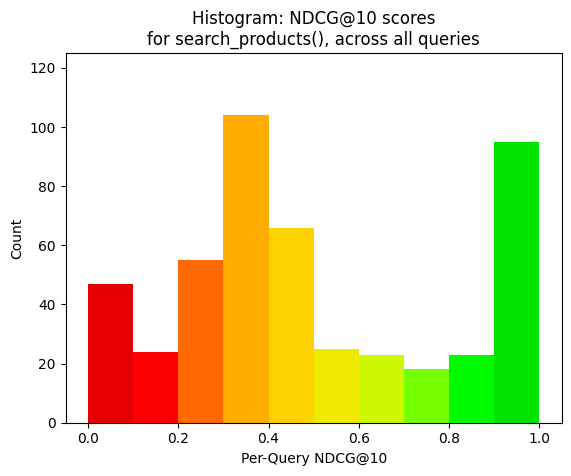

In [45]:
# Composing color-mapped histogram
    # Ref. https://matplotlib.org/stable/gallery/statistics/hist.html

# Setting value for bins parameter
n_bins = 10

fig, ax = plt.subplots()

# Passing arguments into histogram plotting function
# Assigning resultant values for further manipulation
    # N: count in each bin
    # bins: lower-limit of each bin,
    # patches: container object
N, bins, patches = ax.hist(ndcg_dist, bins = n_bins)

# Coloring by bins (x-value)
    # Defining bin-based value for scaling
fracs = bins / bins.max()
    # Normalizing data to 0..1 for colormap (cm) range
        # Adjusting normalization range to capture particular segment of cm
            # Aiming for red-orange-green palette from Task 2c
norm = colors.Normalize(fracs.min() - 0.3, fracs.max() + 1.4)

# Looping through objects, setting nipy_spectral cm color accordingly
    # Cf. https://matplotlib.org/stable/gallery/color/colormap_reference.html#reversed-colormaps
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.nipy_spectral_r(norm(thisfrac))
    thispatch.set_facecolor(color)

ax.set_xlabel("Per-Query NDCG@10")
ax.set_ylabel("Count")
ax.set_ylim(0, 125)
ax.set_title(f"Histogram: NDCG@10 scores\nfor search_products(), across all queries")

plt.show()

_I also trialled some plotting code on [StackOverflow by user ImportanceOfBeingErnest](https://stackoverflow.com/a/50768681) (modified by community; retrieved 2026-02-04; license - CC BY-SA 4.0), but ultimately derived the above just from matplotlib documentation._

---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [46]:
# Task 6a: Index product_class field

# YOUR CODE HERE
products_DF["product_class"]

0                                       Beds
1                               Slow Cookers
2                               Slow Cookers
3               Slicers, Peelers And Graters
4                                 Door Knobs
                        ...                 
42989                          Shower Panels
42990                      Dining Table Sets
42991                      Dining Table Sets
42992    Teen Lounge Furniture|Accent Chairs
42993                             Bar Stools
Name: product_class, Length: 42994, dtype: str

_It appears that there are special characters in that field (see "Teen Lounge Furniture|Accent Chairs," index 42992).<br>I want to confirm that_ `snowball_tokenize()`_can handle such a scenario._

In [ ]:
st_challenge_string = "FileLocation-Directory: C:/Users/leona/ai-engineering-fordham/data/wayfair-products.csv"      # st for snowball_tokenize
print(snowball_tokenize(st_challenge_string))

['fileloc', 'directori', 'c', 'user', 'leona', 'ai', 'engin', 'fordham', 'data', 'wayfair', 'product', 'csv']


In [48]:
class_index, class_lengths = build_index(
    products_DF["product_class"], tokenizer = snowball_tokenize
    )

# Defining multi-field dictionary in advance of new search
bm25f_ndc_dict = {     # ndc for name + description + class
    "indices" : {
        "product_name" : name_index,
        "product_description" : desc_index,
        "product_class" : class_index
        },
    "lengths" : {
        "product_name" : name_lengths,
        "product_description" : desc_lengths,
        "product_class" : class_lengths
        }
    }

_Rather than defining a search function from scratch, I want to try remobilizing_ `search_products_bm25f_blend()`_, which is defined to handle multiple fields.<br><br>So as not to be totally lazy, I offer the idea that future improvement on that function might weigh (dynamically, even!) the fields' respective contributions to tf and idf._

### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [ ]:
# Refreshing memory,
evaluation_sorted = evaluation.sort_values("ndcg", ascending = False)
display(evaluation_sorted)
search_query

,query_id,query,ndcg
463,470,elephant framed,1.0
456,463,bistro sets patio,1.0
28,28,rooster decor,1.0
25,25,sunflower,1.0
433,439,parsons chairs,1.0
...,...,...,...
178,179,promo codes or discounts,0.0
389,395,pantry grey,0.0
204,207,dull bed with shirt head board,0.0
173,174,star wars rug,0.0


'chair'

In [50]:
# Task 6b: Evaluate three-field search

# YOUR CODE HERE
def query_search_ndc(query_text):
    # Using field-blending function as declared above
    return search_products_bm25f_blend(
        query = query_text,
        products_df = products_DF,
        fields = bm25f_ndc_dict
        )[0]

# Taking test values from row 0 of queries_DF
evaluate_single_query(
    query_text = queries_DF.iloc[0]["query"],
    query_id = queries_DF.iloc[0]["query_id"],
    products_df = products_DF,
    labels_df = labels_DF,
    search_func = query_search_ndc
    )

np.float64(1.0)

In [51]:
evaluation_ndc_3 = evaluate_search(
    query_search_ndc,
    products_DF[:3], queries_DF[:3], labels_DF[:3]
    )
display(evaluation_ndc_3)

Evaluated 3 queries
Mean NDCG@10: 0.0212


,query_id,query,ndcg
0,0,salon chair,0.063621
1,1,smart coffee table,0.000000
2,2,dinosaur,0.000000


_The above Cell exhibits an absurdly protracted runtime; the content therein has been swapped to designation_ `raw`_, so that it is preserved but isn't accidentally run again._

_In-person consultations with fellow students Katherine Morris and Ben Ren point to using the naive per-field score summation. Meanwhile, the Cursor assistant suggests rebuilding the underlying search function to reduce the computational burden._

In [68]:
# Crafting dictionary for naive function
bm25_mfn_ndc_dict = {     # bm25_mfn_ndc for bm25 multi-field naive(ly-summed scoring of) name + description + class
    "product_name" : (name_index, name_lengths),
    "product_description" : (desc_index, desc_lengths),
    "product_class" : (class_index, class_lengths)
    }

In [69]:
# Defining another wrapper
def query_search_ndc_take2(query_text):     # take2 for this being second attempt
    # Using naive multi-field now
    product_results_DF = search_products_bm25_mfn(
        query = query_text,
        products_df = products_DF,
        fields = bm25_mfn_ndc_dict
        )
    return product_results_DF[0]

# Taking test values from row 0 of queries_DF
evaluation_ndc_single = evaluate_single_query(
    query_text = queries_DF.iloc[0]["query"],
    query_id = queries_DF.iloc[0]["query_id"],
    products_df = products_DF,
    labels_df = labels_DF,
    search_func = query_search_ndc
    )
display(evaluation_ndc_single)
print(f".iloc[0] test completed")

np.float64(1.0)

.iloc[0] test completed


In [70]:
evaluation_ndc_3 = evaluate_search(
    query_search_ndc_take2,
    products_DF[:3], queries_DF[:3], labels_DF[:3]
    )
display(evaluation_ndc_3)
print(f"[:3] test completed")

Evaluated 3 queries
Mean NDCG@10: 0.0000


,query_id,query,ndcg
0,0,salon chair,0.0
1,1,smart coffee table,0.0
2,2,dinosaur,0.0


[:3] test completed


In [71]:
evaluation_ndc = evaluate_search(
    query_search_ndc_take2,
    products_DF, queries_DF, labels_DF
    )
display(evaluation_ndc)

Evaluated 480 queries
Mean NDCG@10: 0.5260


,query_id,query,ndcg
0,0,salon chair,1.000000
1,1,smart coffee table,0.480061
2,2,dinosaur,1.000000
3,3,turquoise pillows,0.636332
4,4,chair and a half recliner,0.390095
...,...,...,...
475,483,rustic twig,0.463459
476,484,nespresso vertuo next premium by breville with...,0.333333
477,485,pedistole sink,0.120962
478,486,54 in bench cushion,0.333333


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

`evaluation` _and_ `evaluation_ndc` _share most of their fields, a fact I leverage below._

In [82]:
# Task 6c: Compare to baseline

# YOUR CODE HERE
# Copying evaluation DataFrames to preserve previous values
eval_copy = evaluation.copy()
eval_ndc_copy = evaluation_ndc.copy()

# Renaming NDCG columns to reflect fields involved
    # Ref. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
eval_copy.rename(columns = {"ndcg" : "ndcg_n"}, inplace = True)
eval_ndc_copy.rename(columns = {"ndcg" : "ndcg_ndc"}, inplace = True)

# Appending 3-field NDCG and difference columns to eval_copy
eval_copy["ndcg_ndc"] = eval_ndc_copy["ndcg_ndc"]
eval_copy["mvmt."] = eval_copy["ndcg_ndc"] - eval_copy["ndcg_n"]

# Sorting
eval_copy_sorted = eval_copy.sort_values(by = ["mvmt."])
print(f"== BOTTOM 25 WORST DEGRADED ==")
display(eval_copy_sorted.head(25))
print(f"\n== TOP 25 MOST IMPROVED ==")
display(eval_copy_sorted.tail(25))

== BOTTOM 25 WORST DEGRADED ==


,query_id,query,ndcg_n,ndcg_ndc,mvmt.
13,13,outdoor privacy wall,0.914857,0.110046,-0.804811
27,27,outdoor welcome rug,0.647037,0.133361,-0.513677
254,258,breakfast bar table,0.769526,0.355777,-0.413749
163,164,modern outdoor furniture,0.445262,0.073364,-0.371898
147,147,drum picture,0.387335,0.021207,-0.366128
30,30,3 1/2 inch drawer pull,0.853272,0.501136,-0.352136
202,205,ines shag rug w003096809,1.000000,0.684738,-0.315262
216,220,sheets for twinxl,0.907425,0.595519,-0.311906
228,232,storage dresser,0.955831,0.653966,-0.301865
420,426,outdoor storage,0.857205,0.559080,-0.298125



== TOP 25 MOST IMPROVED ==


,query_id,query,ndcg_n,ndcg_ndc,mvmt.
69,69,wall sconce with usb port,0.163216,0.507872,0.344656
132,132,farmhouse cabinet,0.290625,0.642424,0.351799
14,14,beds that have leds,0.426028,0.779908,0.353881
123,123,entrance table,0.082344,0.436748,0.354404
40,40,elegant executive chair,0.463459,0.831136,0.367677
7,7,driftwood mirror,0.526729,0.904803,0.378074
68,68,nautical platters,0.425816,0.812228,0.386412
0,0,salon chair,0.602334,1.000000,0.397666
242,246,clear shower curtain,0.260913,0.668136,0.407223
423,429,gray dresser,0.073364,0.507629,0.434265


_I don't feel confident making unshaking pronouncements about what distinguishes the tumblers from the triumphant, but I will offer a few observations:_
* _Some– but not all– of the queries that improved with tri-field search were pretty narrow: "driftwood" (index 7) and "kelly clarkson" (233) and "sconce" (69) are terms that have low document frequencies across the English language and may have benefitted as the search scope broadened._ 
* _By the same token, some of the queries that degraded also started narrow: "zachary 72.5" (64), "chrome bathroom 4 light vanity light" (18), and especially "ines shag rug w003096809" (205) read like segments of product names; zooming out toward a larger search scope would depress relevance scores._
* _The person searching "desk for kids tjat ate 10 year old" (197) presents an interesting case: accepting lexical matches that latch onto "desk" might bring about furniture that isn't appropriately sized for a child of that height and weight range, yet it's not terribly likely that a table is designated the exclusive province of 10-year-olds._
    * _With an eye toward later course topics, perhaps a semantically-aware web search that could, with the help of medical reference charts, translate age into physical dimensions (height, weight, wingspan) would be particularly nice here._

---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [112]:
# Task 7a: Extract product type, theme, material, color, and any other information you deem relevcant from the query

# YOUR CODE HERE
type_options = products_DF["product_class"]
# Cleanning up values for use in schema
    # Ref. https://pandas.pydata.org/docs/reference/api/pandas.Series.dropna.html
    # Ref. https://pandas.pydata.org/docs/reference/api/pandas.Series.drop_duplicates.html
type_options = products_DF["product_class"].dropna().drop_duplicates()

print(len(type_options))

860


_Apparently this pd.Series is too long for API access. I'll have to drop the idea and use a much simpler schematization for_ `Product.type`_._

In [113]:
class Product(BaseModel):
    """Structured representation of a Wayfair product."""

    # Taking categories from IKEA navigation bar
        # https://www.ikea.com/us/en/
    type: Literal["storage organization", "sofa armchairs",
        "beds mattresses", "kitchen appliances", "tables chairs",
        "kitchenware tableware", "home decor", "lighting",
        "baby kids", "desks deskchairs", "rugs textiles",
        "bathroom supplies", "outdoor", "window treatments",
        "plants", "laundry cleaning", "electronics smart",
        "pet accessories", "home improvement"] = Field(
        description = "Product class")
    theme: str = Field(
        description = "Stylistic, aesthetic, and/or symbolic qualities")
    material: str = Field(
        description  = "Material")
    color: str | None = Field(
        default = None,
        description = "Color")
    usage: list[str] = Field(
        description = "Indoor/outdoor suitability",
        min_length = 1, max_length = 1)
    tagline: str | None = Field(
        default = None, 
        description = "Short (approx. 7 words) sales pitch favorably describing product")

    pass

In [114]:
# Composing function to asynchronously extract products (10 pts)
async def async_extract_product(query: str) -> Product:
    """Extract product data asynchronously."""
    # YOUR CODE HERE
    response = await litellm.acompletion(  # Note: acompletion, not completion!
        model="gpt-5-mini",
        messages=[
            {
                "role": "system",
                "content": "Extract structured information from query for furniture product."
                },
            {
                "role": "user",
                "content": f"Please extract and infer information from this query:\n\n{query}"
                }
            ],
        response_format = Product  # Tell the LLM to return this structure!
        )
    productData_object = Product.model_validate_json(response.choices[0].message.content)

    return productData_object
    # pass

In [115]:
# Test your query understanding function by running it against these test queries
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

async def extract_all_products(queries: list[str]) -> list[Product]:
    """Process all movie descriptions concurrently and return results."""
    # YOUR CODE HERE
    """Process all prompts concurrently."""
    tasks = [async_extract_product(q) for q in test_queries]
    return await asyncio.gather(*tasks)
    # pass

_I triggered this error some several times. Google Gemini suggested setting_ `litellm.set_verbose = True`_, resulting the next great American novel that LiteLLM has handed back. Within, I read that I'm passing_ `nan`_s through_ `list(products_DF["product_class"])`_.<br>I'll go back to adjust the schema to attempt salvaging the use of that column (note: this effort was not successful)._

In [ ]:
start = time.time()
queries_test4 = await extract_all_products(test_queries)     # test4 for four test queries 
elapsed = time.time() - start

print(f"Processed {len(queries_test4)} queries in {elapsed:.2f} seconds")
print()
for q in queries_test4:
    print(f"[{q.type}, {q.theme}, {q.material}, {q.color}]")

22:14:07 - LiteLLM:DEBUG: utils.py:475 - 

22:14:07 - LiteLLM:DEBUG: utils.py:475 - Request to litellm:
22:14:07 - LiteLLM:DEBUG: utils.py:475 - litellm.acompletion(model='gpt-5-mini', messages=[{'role': 'system', 'content': 'Extract structured information from query for furniture product.'}, {'role': 'user', 'content': 'Please extract and infer information from this query:\n\nstar wars rug'}], response_format=<class '__main__.Product'>)


22:14:07 - LiteLLM:DEBUG: utils.py:475 - 

22:14:07 - LiteLLM:WARNING: utils.py:758 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.
22:14:07 - LiteLLM:DEBUG: utils.py:999 - Removing thought signatures from tool call IDs for non-Gemini model
22:14:07 - LiteLLM:DEBUG: litellm_logging.py:523 - self.optional_params: {}
22:14:07 - LiteLLM:DEBUG: utils.py:475 - ASYNC kwargs[caching]: False; litellm.cache: None; kwargs.get('cache'): None
22:14:08 - LiteLLM:DEBUG: main.py:517 - 🔄 NO SHARED SESSION: acompletion called without shared_session
22:14:08 - LiteLLM:DEBUG: utils.py:475 - 





Request to litellm:
litellm.acompletion(model='gpt-5-mini', messages=[{'role': 'system', 'content': 'Extract structured information from query for furniture product.'}, {'role': 'user', 'content': 'Please extract and infer information from this query:\n\nstar wars rug'}], response_format=<class '__main__.Product'>)


ASYNC kwargs[caching]: False; litellm.cache: None; kwargs.get('cache'): None


22:14:08 - LiteLLM:DEBUG: utils.py:475 - Request to litellm:
22:14:08 - LiteLLM:DEBUG: utils.py:5428 - checking potential_model_names in litellm.model_cost: {'split_model': 'gpt-5-mini', 'combined_model_name': 'openai/gpt-5-mini', 'stripped_model_name': 'gpt-5-mini', 'combined_stripped_model_name': 'openai/gpt-5-mini', 'custom_llm_provider': 'openai'}
22:14:08 - LiteLLM:DEBUG: utils.py:475 - litellm.acompletion(model='gpt-5-mini', messages=[{'role': 'system', 'content': 'Extract structured information from query for furniture product.'}, {'role': 'user', 'content': 'Please extract and infer information from this query:\n\nwooden coffee table'}], response_format=<class '__main__.Product'>)
22:14:08 - LiteLLM:INFO: utils.py:3872 - 
LiteLLM completion() model= gpt-5-mini; provider = openai
22:14:08 - LiteLLM:DEBUG: utils.py:475 - 

22:14:08 - LiteLLM:WARNING: utils.py:758 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.
22:14:08 - Lit



Request to litellm:
litellm.acompletion(model='gpt-5-mini', messages=[{'role': 'system', 'content': 'Extract structured information from query for furniture product.'}, {'role': 'user', 'content': 'Please extract and infer information from this query:\n\nwooden coffee table'}], response_format=<class '__main__.Product'>)


ASYNC kwargs[caching]: False; litellm.cache: None; kwargs.get('cache'): None
Final returned optional params: {'response_format': {'type': 'json_schema', 'json_schema': {'schema': {'description': 'Structured representation of a Wayfair product.', 'properties': {'type': {'description': 'Product class', 'enum': ['storage organization', 'sofa armchairs', 'beds mattresses', 'kitchen appliances', 'tables chairs', 'kitchenware tableware', 'home decor', 'lighting', 'baby kids', 'desks deskchairs', 'rugs textiles', 'bathroom supplies', 'outdoor', 'window treatments', 'plants', 'laundry cleaning', 'electronics smart', 'pet accessories', 'home improvement'], 'title': 'Type', 

22:14:08 - LiteLLM:DEBUG: main.py:517 - 🔄 NO SHARED SESSION: acompletion called without shared_session
22:14:08 - LiteLLM:DEBUG: litellm_logging.py:523 - self.optional_params: {'response_format': {'type': 'json_schema', 'json_schema': {'schema': {'description': 'Structured representation of a Wayfair product.', 'properties': {'type': {'description': 'Product class', 'enum': ['storage organization', 'sofa armchairs', 'beds mattresses', 'kitchen appliances', 'tables chairs', 'kitchenware tableware', 'home decor', 'lighting', 'baby kids', 'desks deskchairs', 'rugs textiles', 'bathroom supplies', 'outdoor', 'window treatments', 'plants', 'laundry cleaning', 'electronics smart', 'pet accessories', 'home improvement'], 'title': 'Type', 'type': 'string'}, 'theme': {'description': 'Stylistic, aesthetic, and/or symbolic qualities', 'title': 'Theme', 'type': 'string'}, 'material': {'description': 'Material', 'title': 'Material', 'type': 'string'}, 'color': {'anyOf': [{'type': 'string'}, {'type':



Request to litellm:
litellm.acompletion(model='gpt-5-mini', messages=[{'role': 'system', 'content': 'Extract structured information from query for furniture product.'}, {'role': 'user', 'content': 'Please extract and infer information from this query:\n\nblue leather sofa'}], response_format=<class '__main__.Product'>)


Final returned optional params: {'response_format': {'type': 'json_schema', 'json_schema': {'schema': {'description': 'Structured representation of a Wayfair product.', 'properties': {'type': {'description': 'Product class', 'enum': ['storage organization', 'sofa armchairs', 'beds mattresses', 'kitchen appliances', 'tables chairs', 'kitchenware tableware', 'home decor', 'lighting', 'baby kids', 'desks deskchairs', 'rugs textiles', 'bathroom supplies', 'outdoor', 'window treatments', 'plants', 'laundry cleaning', 'electronics smart', 'pet accessories', 'home improvement'], 'title': 'Type', 'type': 'string'}, 'theme': {'description': 'Stylistic, aesthetic, and/or symbo

22:14:08 - LiteLLM:INFO: utils.py:3872 - 
LiteLLM completion() model= gpt-5-mini; provider = openai
22:14:08 - LiteLLM:DEBUG: utils.py:3875 - 
LiteLLM: Params passed to completion() {'model': 'gpt-5-mini', 'functions': None, 'function_call': None, 'temperature': None, 'top_p': None, 'n': None, 'stream': None, 'stream_options': None, 'stop': None, 'max_tokens': None, 'max_completion_tokens': None, 'modalities': None, 'prediction': None, 'audio': None, 'presence_penalty': None, 'frequency_penalty': None, 'logit_bias': None, 'user': None, 'custom_llm_provider': 'openai', 'response_format': <class '__main__.Product'>, 'seed': None, 'tools': None, 'tool_choice': None, 'max_retries': None, 'logprobs': None, 'top_logprobs': None, 'extra_headers': None, 'api_version': None, 'parallel_tool_calls': None, 'drop_params': None, 'allowed_openai_params': None, 'reasoning_effort': None, 'verbosity': None, 'additional_drop_params': None, 'messages': [{'role': 'system', 'content': 'Extract structured in

Final returned optional params: {'response_format': {'type': 'json_schema', 'json_schema': {'schema': {'description': 'Structured representation of a Wayfair product.', 'properties': {'type': {'description': 'Product class', 'enum': ['storage organization', 'sofa armchairs', 'beds mattresses', 'kitchen appliances', 'tables chairs', 'kitchenware tableware', 'home decor', 'lighting', 'baby kids', 'desks deskchairs', 'rugs textiles', 'bathroom supplies', 'outdoor', 'window treatments', 'plants', 'laundry cleaning', 'electronics smart', 'pet accessories', 'home improvement'], 'title': 'Type', 'type': 'string'}, 'theme': {'description': 'Stylistic, aesthetic, and/or symbolic qualities', 'title': 'Theme', 'type': 'string'}, 'material': {'description': 'Material', 'title': 'Material', 'type': 'string'}, 'color': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'description': 'Color', 'title': 'Color'}, 'usage': {'description': 'Indoor/outdoor suitability', 'items': {'type': 'string'}, 'maxIt

22:14:09 - LiteLLM:DEBUG: litellm_logging.py:1072 - 

POST Request Sent from LiteLLM:
curl -X POST \
https://api.openai.com/v1/ \
-H 'Authorization: Be****MA' \
-d '{'model': 'gpt-5-mini', 'messages': [{'role': 'system', 'content': 'Extract structured information from query for furniture product.'}, {'role': 'user', 'content': 'Please extract and infer information from this query:\n\nblue leather sofa'}], 'response_format': {'type': 'json_schema', 'json_schema': {'schema': {'description': 'Structured representation of a Wayfair product.', 'properties': {'type': {'description': 'Product class', 'enum': ['storage organization', 'sofa armchairs', 'beds mattresses', 'kitchen appliances', 'tables chairs', 'kitchenware tableware', 'home decor', 'lighting', 'baby kids', 'desks deskchairs', 'rugs textiles', 'bathroom supplies', 'outdoor', 'window treatments', 'plants', 'laundry cleaning', 'electronics smart', 'pet accessories', 'home improvement'], 'title': 'Type', 'type': 'string'}, 'theme': 

Async Wrapper: Completed Call, calling async_success_handler: <bound method Logging.async_success_handler of <litellm.litellm_core_utils.litellm_logging.Logging object at 0x0000027DD4F3BCB0>>


22:14:17 - LiteLLM:DEBUG: litellm_logging.py:3083 - Filtered callbacks: []
22:14:17 - LiteLLM:DEBUG: utils.py:475 - Logging Details LiteLLM-Async Success Call, cache_hit=None
22:14:17 - LiteLLM:DEBUG: utils.py:475 - Async success callbacks: Got a complete streaming response
22:14:17 - LiteLLM:DEBUG: litellm_logging.py:2387 - Model=gpt-5-mini; cost=0.0005505


Logging Details LiteLLM-Async Success Call, cache_hit=None
Async success callbacks: Got a complete streaming response


22:14:19 - LiteLLM:DEBUG: litellm_logging.py:1145 - RAW RESPONSE:
{"id": "chatcmpl-D5k6loGmG0gc3gj4IzJMK4UwdYX3V", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "{\"type\":\"sofa armchairs\",\"theme\":\"modern\",\"material\":\"leather\",\"color\":\"blue\",\"usage\":[\"indoor\"],\"tagline\":\"Luxurious blue leather sofa for modern living\"}", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}}], "created": 1770261251, "model": "gpt-5-mini-2025-08-07", "object": "chat.completion", "service_tier": "default", "system_fingerprint": null, "usage": {"completion_tokens": 499, "prompt_tokens": 274, "total_tokens": 773, "completion_tokens_details": {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 448, "rejected_prediction_tokens": 0}, "prompt_tokens_details": {"audio_tokens": 0, "cached_tokens": 0}}}


22:14:19 - LiteLLM:DEBUG: litellm_logging.py:3083 - Filtered ca

Async Wrapper: Completed Call, calling async_success_handler: <bound method Logging.async_success_handler of <litellm.litellm_core_utils.litellm_logging.Logging object at 0x0000027DD4F3BB60>>
Logging Details LiteLLM-Async Success Call, cache_hit=None
Async success callbacks: Got a complete streaming response


22:14:20 - LiteLLM:DEBUG: litellm_logging.py:1145 - RAW RESPONSE:
{"id": "chatcmpl-D5k6lz3zYDVd1vtXlF4BIUhmuyJnz", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "{\"type\":\"rugs textiles\",\"theme\":\"Star Wars (galactic / sci-fi)\",\"material\":\"synthetic fibers (polyester/polypropylene)\",\"color\":\"multi-color (predominantly black/gray)\",\"usage\":[\"indoor\"],\"tagline\":\"Iconic Star Wars rug for galactic style\"}", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}}], "created": 1770261251, "model": "gpt-5-mini-2025-08-07", "object": "chat.completion", "service_tier": "default", "system_fingerprint": null, "usage": {"completion_tokens": 523, "prompt_tokens": 274, "total_tokens": 797, "completion_tokens_details": {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 448, "rejected_prediction_tokens": 0}, "prompt_tokens_details": {"audio_tokens": 0, "c

Async Wrapper: Completed Call, calling async_success_handler: <bound method Logging.async_success_handler of <litellm.litellm_core_utils.litellm_logging.Logging object at 0x0000027DBF737230>>
Logging Details LiteLLM-Async Success Call, cache_hit=None
Async success callbacks: Got a complete streaming response


22:14:23 - LiteLLM:DEBUG: litellm_logging.py:1145 - RAW RESPONSE:
{"id": "chatcmpl-D5k6l240YUGIHAblBWbquAyPzZMtq", "choices": [{"finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "{\"type\":\"tables chairs\",\"theme\":\"natural rustic / minimalist\",\"material\":\"solid wood (e.g., oak, teak) or veneered wood\",\"color\":\"natural brown / wood finish\",\"usage\":[\"indoor','living room\"],\"tagline\":\"Natural wood coffee table \u2014 timeless living centerpiece\"}", "refusal": null, "role": "assistant", "annotations": [], "audio": null, "function_call": null, "tool_calls": null}}], "created": 1770261251, "model": "gpt-5-mini-2025-08-07", "object": "chat.completion", "service_tier": "default", "system_fingerprint": null, "usage": {"completion_tokens": 775, "prompt_tokens": 275, "total_tokens": 1050, "completion_tokens_details": {"accepted_prediction_tokens": 0, "audio_tokens": 0, "reasoning_tokens": 704, "rejected_prediction_tokens": 0}, "prompt_tokens_detail

Async Wrapper: Completed Call, calling async_success_handler: <bound method Logging.async_success_handler of <litellm.litellm_core_utils.litellm_logging.Logging object at 0x0000027DD4F3BA10>>
Processed 4 queries in 15.51 seconds

[rugs textiles, Star Wars (galactic / sci-fi), synthetic fibers (polyester/polypropylene), multi-color (predominantly black/gray)]
[tables chairs, natural rustic / minimalist, solid wood (e.g., oak, teak) or veneered wood, natural brown / wood finish]
[sofa armchairs, modern, leather, blue]
[storage organization, modern, metal, None]


22:14:23 - LiteLLM:DEBUG: utils.py:475 - Logging Details LiteLLM-Async Success Call, cache_hit=None
22:14:23 - LiteLLM:DEBUG: utils.py:475 - Async success callbacks: Got a complete streaming response
22:14:23 - LiteLLM:DEBUG: litellm_logging.py:2387 - Model=gpt-5-mini; cost=0.00161875


Logging Details LiteLLM-Async Success Call, cache_hit=None
Async success callbacks: Got a complete streaming response


_Pulling from that "complete streaming response":_<br>
>> [rugs textiles, Star Wars (galactic / sci-fi), synthetic fibers (polyester/polypropylene), multi-color (predominantly black/gray)]<br><br>
>> [tables chairs, natural rustic / minimalist, solid wood (e.g., oak, teak) or veneered wood, natural brown / wood finish]<br><br>
>> [sofa armchairs, modern, leather, blue]<br><br>
>> [storage organization, modern, metal, None]<br><br>

In [117]:
litellm.set_verbose = False

### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [128]:
# Task 7b: Create an LLM-enhanced search

# YOUR CODE HERE
products_DF

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0
...,...,...,...,...,...,...,...,...,...
42989,42989,malibu pressure balanced diverter fixed shower...,Shower Panels,Home Improvement / Bathroom Remodel & Bathroom...,the malibu pressure balanced diverter fixed sh...,producttype : shower panel|spraypattern : rain...,3.0,4.5,2.0
42990,42990,emmeline 5 piece breakfast dining set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,NaN,basematerialdetails : steel| : gray wood|ofhar...,1314.0,4.5,864.0
42991,42991,maloney 3 piece pub table set,Dining Table Sets,Furniture / Kitchen & Dining Furniture / Dinin...,this pub table set includes 1 counter height t...,additionaltoolsrequirednotincluded : power dri...,49.0,4.0,41.0
42992,42992,fletcher 27.5 '' wide polyester armchair,Teen Lounge Furniture|Accent Chairs,Furniture / Living Room Furniture / Chairs & S...,"bring iconic , modern style to your space in a...",legmaterialdetails : rubberwood|backheight-sea...,1746.0,4.5,1226.0


_I sketch out my intentions:_
1. _Using list comprehension: Slice_ `products_DF`_, passing contents of_ `product_name` _column through LLM; return tuples pairing_ `product_id` _and the schematized Product object._
2. _Tokenize each_ `Product.type` _using_ `snowball_tokenize()`_._
3. _For each token of a given Product's (capital P for schema) matching, by "internal search", that product's (lowercase p for document)_ `product_class`_, boost the document's_ `score` _by multiplying it by_ $1.1$_._
4. _Return top "external search" results for a provided text query on the basis of boosted_ `score`_s._

In [ ]:
# YOUR CODE HERE
# Redefining function to incorporate LLM action
def score_bm25_c_llm(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
    tokenizer = snowball_tokenize,
    k1: float = 1.2, b: float = 0.75) -> np.ndarray:     # c_llm for LLM acting on class field
    
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
                
                
    
    return scores

def search_products_c_llm(query: str, products_df: pd.DataFrame, index: dict, 
    doc_lengths: list[int],
    tokenizer = snowball_tokenize, k: int = 10) -> pd.DataFrame:
    
    scores = score_bm25_c_llm(query, index, len(products_df), doc_lengths, tokenizer)
    
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

In [ ]:
async def extract_all_products(queries: list[str]) -> list[Product]:
    """Process all movie descriptions concurrently and return results."""
    # YOUR CODE HERE
    """Process all prompts concurrently."""

    
    tasks = [(id, async_extract_product(q)) for (index, id, q) in products_DF[["product_id", "product_name"]]]
    return await asyncio.gather(*tasks)
    # pass

---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
